In [1]:
%load_ext autoreload
%autoreload 2

import os

subj = "Subj3"

match subj:
    case 'Subj1':
        N_STAGES = 9
    case 'Subj2':
        N_STAGES = 8
    case 'Subj3':
        N_STAGES = 10

exp = "exp_full_flow"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

In [2]:
import typing

import mne
import umap
import tqdm
import numpy
import pandas
import joblib
import itertools
import IPython.display
import sklearn.metrics
import matplotlib.colors
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
import matplotlib.pyplot as plt
import sklearn.cross_decomposition

import SDA.topology
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

from full_flow.AutoEncoder import AutoEncoder

In [3]:
match subj:
    case 'Subj1':
        QSDA_THRESHOLD = 0.4
    case 'Subj2':
        QSDA_THRESHOLD = 0.28
    case 'Subj3':
        QSDA_THRESHOLD = 0.32
        
UNIQUE_VALUES_THRESHOLD = 200
TRY_NUM_FEATURES = list(range(10, 201, 10))

print(len(TRY_NUM_FEATURES))
print(TRY_NUM_FEATURES)

20
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [4]:
def explained_variance(features, reduced):
    pls = sklearn.cross_decomposition.PLSRegression(n_components = reduced.shape[1])
    pls = pls.fit(reduced, features)
    y_pred = pls.predict(reduced)
    return sklearn.metrics.r2_score(features, y_pred, multioutput = "variance_weighted")

### Data

Opening raw data file Subj3/src/data_rr_filt-raw.fif...
    Range : 3000 ... 654000 =      6.000 ...  1308.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj3\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


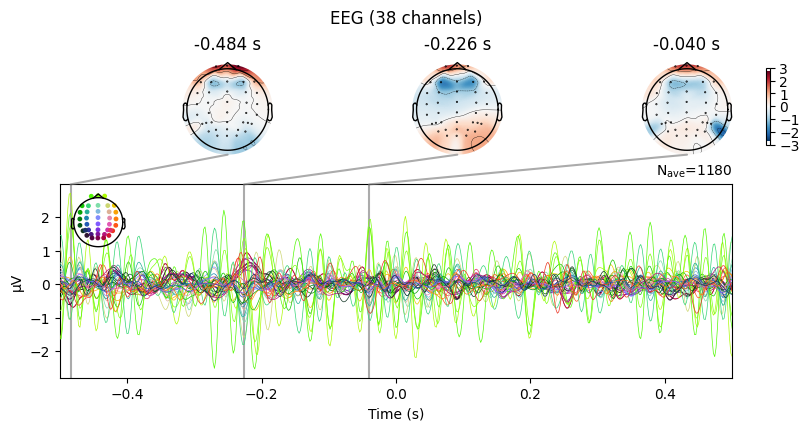

In [5]:
edges_true = numpy.loadtxt(f"{subj}/{exp}/target_edges.txt").astype(numpy.int32)

raw_data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif").drop_channels(ch_names = [ "A1", "A2" ])
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif").drop_channels(ch_names = [ "A1", "A2" ])
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]

epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)

### Features

In [6]:
per_channel_folder = f"{subj}/{exp}/features/per_channel"
os.makedirs(per_channel_folder, exist_ok = True)
per_channel_extractor = SDA.topology.PerChannelFeatureExtractor(n_jobs = -1, folder = per_channel_folder)
per_channel_features = per_channel_extractor.extract(data)

dissimilarity_folder = f"{subj}/{exp}/features/dissimilarity"
os.makedirs(dissimilarity_folder, exist_ok = True)
dissimilarity_extractor = SDA.topology.DissimilarityFeatureExtractor(n_jobs = -1, folder = dissimilarity_folder)
dissimilarity_features = dissimilarity_extractor.extract(data)

overall_folder = f"{subj}/{exp}/features/overall"
os.makedirs(overall_folder, exist_ok = True)
overall_extractor = SDA.topology.OverallFeatureExtractor(n_jobs = -1, folder = overall_folder)
overall_features = overall_extractor.extract(data)

all_features = pandas.concat([
    per_channel_features,
    dissimilarity_features,
    overall_features
], axis = 1)

all_features.to_feather(f"{subj}/{exp}/features/all_features.feather")
display(all_features)

Got features from Subj3/exp_full_flow/features/per_channel/features.feather
Got features from Subj3/exp_full_flow/features/dissimilarity/features.feather
Got features from Subj3/exp_full_flow/features/overall/features.feather


,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,6.0,0.0,1.370689,0.0,0.0,0.0,0.0,11.680021,-0.282410,44.0,...,0.000139,0.000010,0.001111,0.000133,0.000142,0.000145,-0.805189,-0.685159,0.001111,0.000394
1,9.0,0.0,1.569919,0.0,0.0,0.0,0.0,15.823569,0.673523,50.0,...,0.000119,0.000008,0.000596,0.000114,0.000119,0.000128,-1.362588,-0.238580,0.000596,0.000267
2,5.0,0.0,1.355870,0.0,0.0,0.0,0.0,9.881596,-1.118458,46.0,...,0.000123,0.000004,0.006523,0.000121,0.000123,0.000125,0.185416,0.207489,0.006523,0.000896
3,10.0,0.0,2.040004,0.0,0.0,0.0,0.0,16.339947,-0.963733,56.0,...,0.000124,0.000009,0.001853,0.000123,0.000124,0.000125,2.881200,0.739001,0.001853,0.000480
4,13.0,0.0,2.164918,0.0,0.0,0.0,0.0,26.690435,0.537569,48.0,...,0.000103,0.000007,0.001233,0.000101,0.000107,0.000108,-0.678485,-1.097314,0.001233,0.000357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,12.0,0.0,2.030077,0.0,0.0,0.0,0.0,16.590182,1.137308,66.0,...,0.000163,0.000013,0.002612,0.000153,0.000158,0.000176,-1.215499,0.470999,0.002612,0.000655
1176,7.0,0.0,1.230915,0.0,0.0,0.0,0.0,11.493600,1.429831,50.0,...,0.000160,0.000013,0.002074,0.000153,0.000153,0.000157,-0.264364,1.194317,0.002074,0.000577
1177,5.0,0.0,1.563472,0.0,0.0,0.0,0.0,24.753944,-2.917854,56.0,...,0.000150,0.000010,0.001945,0.000145,0.000147,0.000151,0.384305,0.913014,0.001945,0.000541
1178,14.0,0.0,2.291839,0.0,0.0,0.0,0.0,17.132441,2.039008,72.0,...,0.000166,0.000005,0.002487,0.000161,0.000165,0.000170,-1.457446,0.103363,0.002487,0.000642


In [7]:
features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
features = pandas.DataFrame(features, columns = all_features.columns)

features.to_feather(f"{subj}/{exp}/features/features.feather")
display(features)

numpy.save(f"{subj}/{exp}/features/features.npy", features.to_numpy())

,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,-0.895191,0.0,-0.998196,0.0,0.029123,0.0,0.0,-0.225988,-0.652827,-1.560972,...,-1.022870,0.295427,-0.958379,-1.073142,-0.906861,-0.926548,-0.459497,-1.028034,-0.958379,-1.158961
1,0.129042,0.0,-0.491728,0.0,0.029123,0.0,0.0,0.453985,0.125235,-1.061032,...,-1.601325,0.045158,-1.123139,-1.645848,-1.589985,-1.428025,-0.730805,-0.491650,-1.123139,-1.522835
2,-1.236601,0.0,-1.035867,0.0,0.029123,0.0,0.0,-0.521116,-1.333311,-1.394326,...,-1.485366,-0.894454,0.773613,-1.438846,-1.466511,-1.501383,0.022671,0.044122,0.773613,0.287069
3,0.470452,0.0,0.703284,0.0,0.029123,0.0,0.0,0.538725,-1.207376,-0.561091,...,-1.471307,0.163397,-0.720687,-1.384462,-1.431174,-1.499652,1.334819,0.682518,-0.720687,-0.911048
4,1.494685,0.0,1.020830,0.0,0.029123,0.0,0.0,2.237281,0.014578,-1.227679,...,-2.081517,-0.158061,-0.919042,-2.034799,-1.945593,-1.979926,-0.397824,-1.523070,-0.919042,-1.264197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,1.153274,0.0,0.678048,0.0,0.029123,0.0,0.0,0.579789,0.502724,0.272143,...,-0.304442,0.892966,-0.477833,-0.471369,-0.451121,-0.069024,-0.659211,0.360622,-0.477833,-0.407156
1176,-0.553780,0.0,-1.353518,0.0,0.029123,0.0,0.0,-0.256580,0.740816,-1.061032,...,-0.413742,0.917383,-0.650040,-0.464590,-0.586132,-0.594048,-0.196255,1.229396,-0.650040,-0.631255
1177,-1.236601,0.0,-0.508118,0.0,0.029123,0.0,0.0,1.919495,-2.797893,-0.561091,...,-0.704748,0.469052,-0.691238,-0.708313,-0.768498,-0.769988,0.119479,0.891525,-0.691238,-0.735386
1178,1.836096,0.0,1.343479,0.0,0.029123,0.0,0.0,0.668776,1.236643,0.772083,...,-0.230450,-0.589176,-0.517991,-0.215588,-0.247968,-0.231768,-0.776976,-0.080943,-0.517991,-0.443412


### Feature selection

In [8]:
os.makedirs(f"{subj}/{exp}/qsda", exist_ok = True)
qsda = SDA.QSDA(
    n_jobs = 1,
    qsda_n_jobs = 14,
    scores_folder = f"{subj}/{exp}/qsda",

    threshold = QSDA_THRESHOLD,
    min_unique_values = UNIQUE_VALUES_THRESHOLD
)
best_features, scores = qsda.select(features)

best_features.to_feather(f"{subj}/{exp}/qsda/best_features.feather")
numpy.save(f"{subj}/{exp}/qsda/best_features.npy", features.to_numpy())
display(best_features)
display(scores)

,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 percentile-75,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 sum,channel-0 landscape dim-2 norm-1,...,overall bd2 dim-2 max,overall bd2 dim-2 mean,overall bd2 dim-2 percentile-25,overall bd2 dim-2 median,overall bd2 dim-2 percentile-75,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75
0,-1.113341,-1.019468,-1.174500,-1.019468,-0.591658,-1.019468,-1.136521,-1.061957,-1.061957,-1.061957,...,-1.282095,-1.331525,-1.351234,-1.316114,-1.322537,-1.014209,-1.022870,-1.073142,-0.906861,-0.926548
1,-1.053313,-1.026749,-1.163463,-1.026749,-0.591658,-1.026749,-1.129571,-1.004580,-1.004580,-1.004580,...,-1.333168,-1.605433,-1.766583,-1.477456,-1.464387,-1.549017,-1.601325,-1.645848,-1.589985,-1.428025
2,-0.607048,-0.873113,-0.824961,-0.873113,-0.591658,-0.873113,-0.837102,-0.754710,-0.754710,-0.754710,...,-1.590156,-1.598196,-1.518950,-1.589670,-1.605872,-1.464972,-1.485366,-1.438846,-1.466511,-1.501383
3,-1.460095,-1.209325,-1.405180,-1.209325,-0.591658,-1.209325,-1.352908,-0.937751,-0.937751,-0.937751,...,-1.281517,-1.601469,-1.642899,-1.594179,-1.607556,-1.026936,-1.471307,-1.384462,-1.431174,-1.499652
4,-1.997381,-1.477099,-1.864918,-1.477099,-0.591658,-1.477099,-1.759929,-1.116152,-1.116152,-1.116152,...,-1.971618,-2.291093,-2.378357,-2.227511,-2.192680,-2.067566,-2.081517,-2.034799,-1.945593,-1.979926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,0.337827,-0.176050,0.125975,-0.176050,-0.591658,-0.176050,0.042255,-0.538240,-0.538240,-0.538240,...,0.897194,0.017755,-0.184319,0.032023,0.011144,-0.034710,-0.304442,-0.471369,-0.451121,-0.069024
1176,1.017671,-0.007321,0.332075,-0.007321,-0.591658,-0.007321,0.237597,-0.768525,-0.768525,-0.768525,...,-0.339955,-0.383142,-0.489351,-0.538800,-0.114161,-0.101337,-0.413742,-0.464590,-0.586132,-0.594048
1177,-0.158090,-0.253397,-0.480465,-0.253397,0.212807,-0.253397,-0.426909,-0.766212,-0.766212,-0.766212,...,-0.537510,-0.719330,-0.788041,-0.760155,-0.624797,-0.398935,-0.704748,-0.708313,-0.768498,-0.769988
1178,0.680569,-0.458175,-0.100489,-0.458175,-0.591658,-0.458175,-0.193293,-0.172981,-0.172981,-0.172981,...,-0.431671,-0.285034,-0.200981,-0.293858,-0.369690,-0.395732,-0.230450,-0.215588,-0.247968,-0.231768


,name,score,mean,variance,unique_values,normalized_score
0,channel-0 betti dim-1 max,0.521566,-2.589266e-16,1.0,20,0.100317
1,channel-0 betti dim-1 mean,0.000000,0.000000e+00,0.0,1,0.000247
2,channel-0 betti dim-1 std,0.425125,-7.587151e-16,1.0,284,0.081813
3,channel-0 betti dim-1 sum,0.000000,0.000000e+00,0.0,1,0.000247
4,channel-0 betti dim-1 percentile-25,3.106527,6.021549e-18,1.0,2,0.596277
...,...,...,...,...,...,...
19138,overall bd2 dim-3 percentile-75,1.897090,2.649481e-16,1.0,1178,0.364230
19139,overall bd2 dim-3 kurtosis,1.380404,0.000000e+00,1.0,1157,0.265096
19140,overall bd2 dim-3 skew,0.205522,1.505387e-17,1.0,1159,0.039679
19141,overall bd2 dim-3 norm-1,0.989711,0.000000e+00,1.0,1178,0.190137


### Dimensionality reduction

In [9]:
print(TRY_NUM_FEATURES)
for n_components in TRY_NUM_FEATURES:
    file = f"{subj}/{exp}/features_reduced/rtd_ae/{n_components}/features.npy"
    if not os.path.exists(file):
        raise NotImplementedError(f'Need to run RTD_AE for {n_components} components manually')

class RTDAutoEncoder:
    def __init__(self, n_components: int):
        self.n_components = n_components

    def fit_transform(self, features: numpy.ndarray):
        return numpy.load(f"{subj}/{exp}/features_reduced/rtd_ae/{self.n_components}/features.npy")

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [10]:
def make_reduced(
    methods: typing.List[typing.Tuple[str, typing.Callable[[numpy.ndarray], numpy.ndarray]]],
    full_features: pandas.DataFrame
):
    def reduce(name: str, method, n_components: int, full_features: numpy.ndarray):
        folder = f"{subj}/{exp}/features_reduced/{name}/{n_components}"
        os.makedirs(folder, exist_ok = True)
        
        features_file = f"{folder}/features.npy"
        if os.path.exists(features_file):
            reduced_features = numpy.load(features_file)
        else:
            reduced_features = method.fit_transform(full_features)
            numpy.save(features_file, reduced_features)
        
        explained_variance_file = f"{folder}/explained_variance.txt"
        if not os.path.exists(explained_variance_file):
            ev = explained_variance(full_features, reduced_features)
            numpy.savetxt(explained_variance_file, [ ev ])
        
        results_file = f"{folder}/results.csv"
        if not os.path.exists(results_file):
            sda = SDA.SDA(n_jobs = 1, scale = False, verbose = False, st1_calc_quality = False)
            results, _ = sda.apply(reduced_features)
            results.to_csv(results_file, index = False)

    generator = joblib.Parallel(return_as = "generator", n_jobs = 15)(
        joblib.delayed(reduce)(name, method(n_components = n_components, **params), n_components, full_features.to_numpy())
        for n_components, (name, method, params) in itertools.product(TRY_NUM_FEATURES, methods)
    )
    list(tqdm.tqdm(generator, total = len(methods) * len(TRY_NUM_FEATURES)))

methods = [
    ('pca', sklearn.decomposition.PCA, { 'svd_solver': "full", 'random_state': 42 }),
    ('umap', umap.UMAP, { 'random_state': 42 }),
    ('ae', AutoEncoder, { 'n_features': best_features.shape[1] }),
    ('rtd_ae', RTDAutoEncoder, { })
]
make_reduced(methods, best_features)

 24%|██▍       | 19/80 [16:06<39:13, 38.59s/it]  d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 80/80 [1:03:59<00:00, 47.99s/it]


pca: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


TypeError: object of type 'Axes' has no len()

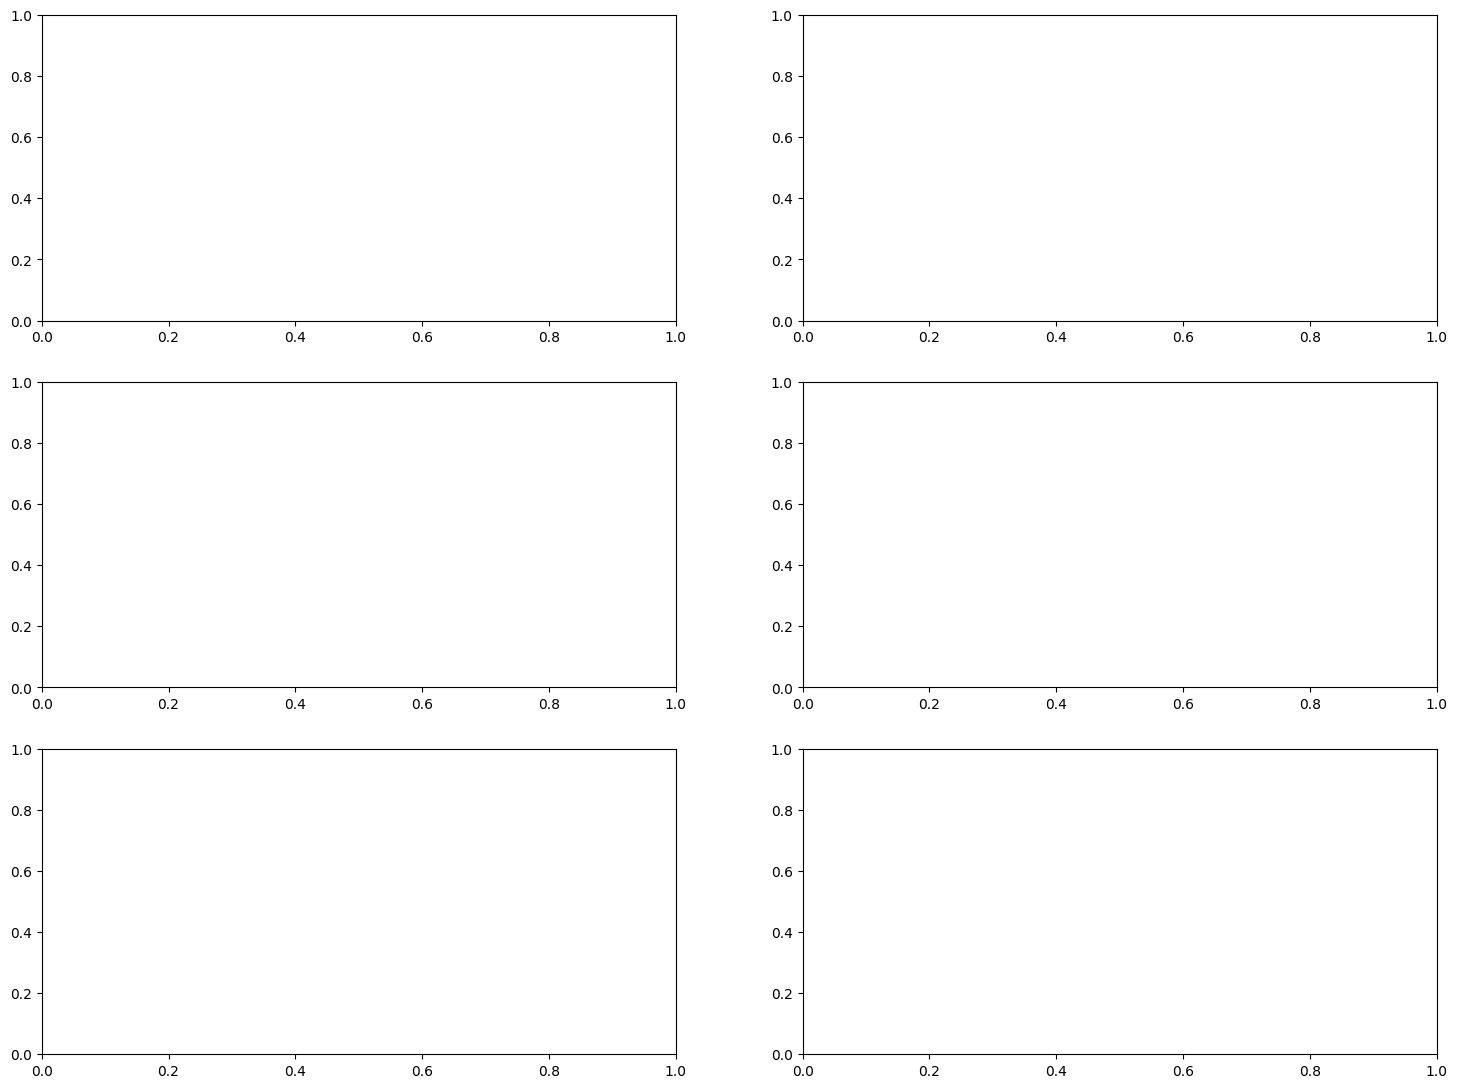

In [13]:
fig, axes = plt.subplots(3, 2, figsize = (18, 13.5))
ax_fmi, ax_silh_all, ax_silh_best, _, ax_explained_variance, ax_silh_reduced = axes.flat

for (name, _, __) in methods:
    fmis = [ ]
    silh_all = [ ]
    silh_best = [ ]
    silh_reduced = [ ]
    explained_variance = [ ]

    for n_components in tqdm.tqdm(TRY_NUM_FEATURES, desc = name):
        folder = f"{subj}/{exp}/features_reduced/{name}/{n_components}"

        reduced_features = numpy.load(f"{folder}/features.npy")
        assert reduced_features.shape == (data.shape[0], n_components)

        explained_variance.append(float(numpy.loadtxt(f"{folder}/explained_variance.txt")))

        results = pandas.read_csv(f"{folder}/results.csv")
        try:
            result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
            edges = numpy.fromstring(result['St_edges'].strip('[]'), sep = ' ', dtype = numpy.uint)
        except:
            edges = None
    
        if edges is not None:
            fmis.append(SDA.clustquality.cluster_metrics_ground(edges_true, edges, [ "FMI" ])["FMI"])
            silh_all.append(SDA.clustquality.calc_stage_metr_noground(features, edges, [ "Silh" ]).mean()["Silh"])
            silh_best.append(SDA.clustquality.calc_stage_metr_noground(best_features, edges, [ "Silh" ]).mean()["Silh"])
            silh_reduced.append(SDA.clustquality.calc_stage_metr_noground(reduced_features, edges, [ "Silh" ]).mean()["Silh"])
        else:
            if len(fmis) > 0: fmis.append(fmis[-1])
            if len(silh_all) > 0: silh_all.append(silh_all[-1])
            if len(silh_best) > 0: silh_best.append(silh_best[-1])
            if len(silh_reduced) > 0: silh_reduced.append(silh_reduced[-1])

    while len(fmis) < len(TRY_NUM_FEATURES): fmis.insert(0, fmis[0])
    while len(silh_all) < len(TRY_NUM_FEATURES): silh_all.insert(0, silh_all[0])
    while len(silh_best) < len(TRY_NUM_FEATURES): silh_best.insert(0, silh_best[0])
    while len(silh_reduced) < len(TRY_NUM_FEATURES): silh_reduced.insert(0, silh_reduced[0])

    ax_fmi.plot(TRY_NUM_FEATURES, fmis, label = name)
    ax_silh_all.plot(TRY_NUM_FEATURES, silh_all, label = name)
    ax_silh_best.plot(TRY_NUM_FEATURES, silh_best, label = name)
    ax_silh_reduced.plot(TRY_NUM_FEATURES, silh_reduced, label = name)
    ax_explained_variance.plot(TRY_NUM_FEATURES, explained_variance, label = name)

ax_fmi.yaxis.set_label_text("FMI")
ax_explained_variance.yaxis.set_label_text("Explained variance")
ax_silh_all.yaxis.set_label_text("Silhouette against all features")
ax_silh_best.yaxis.set_label_text("Silhouette against best features")
ax_silh_reduced.yaxis.set_label_text("Silhouette against reduced features")

for ax in axes.flat:
    ax.legend()
    ax.xaxis.set_label_text('Number of components')

fig.savefig(f"{subj}/{exp}/features_reduced/comparison.svg")

### Results

#### Estimator

In [14]:
def analyze(all_features: pandas.DataFrame, n_components: int, folder: str):
    folder = f"{subj}/{exp}/results/{folder}"
    os.makedirs(folder, exist_ok = True)

    # Scale features
    all_features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
    print(all_features.shape)
    numpy.save(f"{folder}/all_features.npy", all_features)
    numpy.savetxt(f"{folder}/all_features_shape.txt", all_features.shape)

    # PCA
    pca = sklearn.decomposition.PCA(n_components = n_components, svd_solver = "full", random_state = 42)
    pca_features = pca.fit_transform(all_features)
    print(pca_features.shape)
    numpy.save(f"{folder}/pca_features.npy", pca_features)
    numpy.savetxt(f"{folder}/pca_features_shape.txt", pca_features.shape)
    
    print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
    print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
    numpy.savetxt(f"{folder}/explained_variance.txt", [ pca.explained_variance_ratio_.sum() ])
    numpy.savetxt(f"{folder}/explained_variance_ratios.txt", pca.explained_variance_ratio_)

    # SDA
    sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
    results, df_st_edges = sda.apply(pca_features)
    
    metrics = [ ]
    for row in tqdm.tqdm(results['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    results = pandas.concat([ results, pandas.DataFrame(metrics) ], axis = 1)
    
    results.to_csv(f"{folder}/results.csv")
    df_st_edges.to_csv(f"{folder}/df_st_edges.csv")

    # Analyze
    best_results = SDA.analytics.best_results(results, key = 'Avg-Silh')
    best_results.to_csv(f"{folder}/best_results.csv")
    
    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_eeg_stages(raw_data, best_edges, epochs).savefig(f"{folder}/eeg_stages.svg")
    SDA.analytics.plot_stats(pca_features, epochs, best_result, df_st_edges).savefig(f"{folder}/stats.svg")

#### Традиционные признаки

(2017, 765)
(2017, 15)
Explained variance 0.6
[0.17, 0.092, 0.084, 0.057, 0.033, 0.025, 0.024, 0.02, 0.018, 0.016, 0.015, 0.012, 0.012, 0.011, 0.01]
Applying to 2017 samples with 15 features each


100%|██████████| 1344/1344 [00:05<00:00, 235.57it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,20,Mode,40,"[0, 370, 526, 906, 1052, 1275, 1489, 1857, 2017]",8,380,146,252.125,...,12.825887,0.034544,139.666913,3.542148,0.109779,65.016172,2.852257,1.0,1.0,1.0


array([   0,  370,  526,  906, 1052, 1275, 1489, 1857, 2017])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(10.5, 434.5)","(436.5, 618.5)","(619.5, 1069.5)","(1071.5, 1240.5)","(1242.5, 1502.5)","(1503.5, 1750.5)","(1752.5, 2169.5)","(2170.5, 2345.5)"
"Time length, sec",424.0,182.0,450.0,169.0,260.0,247.0,417.0,175.0
Number of epochs,370,156,380,146,223,214,368,160


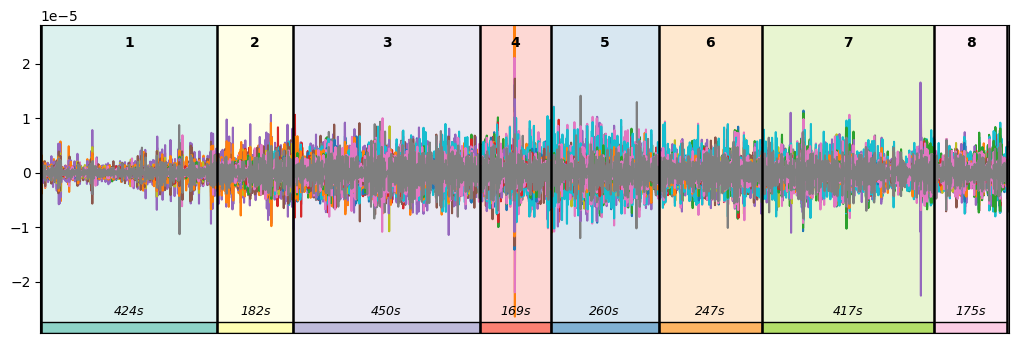

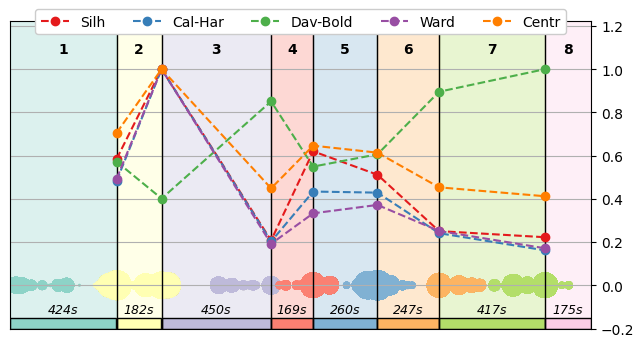

In [15]:
def read_traditional():
    df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
    df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
    df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
    df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

    result =  pandas.concat([
        df_ft_psd_loc_db,
        df_ft_psd_ind_loc_log,
        df_ft_coh_ind_loc,
        df_ft_plv_ind_loc
    ], axis = 1)

    if subj == "Subj2":
        result = result[:-2]
    return result

analyze(read_traditional(), 15, "traditional")

#### Топологические признаки + PCA

(2017, 19143)
(2017, 15)
Explained variance 0.19
[0.072, 0.018, 0.015, 0.01, 0.008, 0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006]
Applying to 2017 samples with 15 features each


100%|██████████| 1344/1344 [00:06<00:00, 215.94it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,45,15,Median,40,"[0, 201, 350, 507, 838, 1076, 1174, 1795, 2017]",8,621,98,252.125,...,24.469755,-0.035753,68.224472,5.439122,0.050738,23.243813,4.328792,0.741266,0.54364,0.617232


array([   0,  201,  350,  507,  838, 1076, 1174, 1795, 2017])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(10.5, 237.5)","(238.5, 413.5)","(414.5, 593.5)","(596.5, 991.5)","(992.5, 1272.5)","(1273.5, 1389.5)","(1390.5, 2101.5)","(2102.5, 2345.5)"
"Time length, sec",227.0,175.0,179.0,395.0,280.0,116.0,711.0,243.0
Number of epochs,201,149,157,331,238,98,621,222


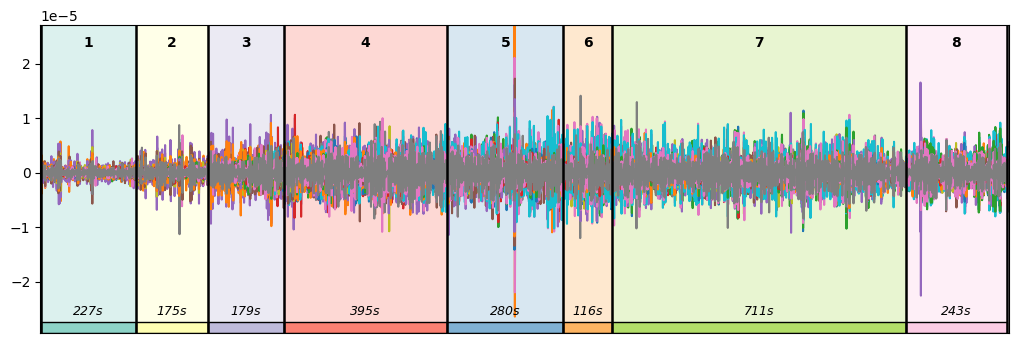

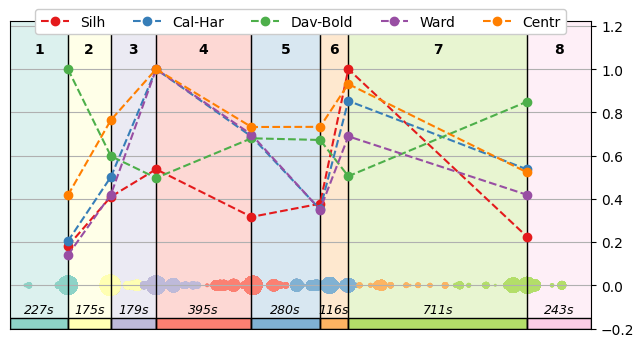

In [16]:
analyze(features, 15, "topological")

#### Топологические признаки + QSDA + PCA

(2017, 1650)
(2017, 15)
Explained variance 0.5
[0.089, 0.044, 0.038, 0.034, 0.033, 0.03, 0.029, 0.028, 0.027, 0.027, 0.025, 0.024, 0.023, 0.023, 0.022]
Applying to 2017 samples with 15 features each


100%|██████████| 1344/1344 [00:05<00:00, 237.28it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,20,Median,40,"[0, 372, 542, 646, 994, 1116, 1275, 1795, 2017]",8,520,104,252.125,...,12.260552,-0.103894,37.253267,4.585363,0.131402,22.169541,4.140108,0.807293,0.671382,0.722587


array([   0,  372,  542,  646,  994, 1116, 1275, 1795, 2017])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(10.5, 437.5)","(438.5, 637.5)","(638.5, 762.5)","(763.5, 1170.5)","(1171.5, 1323.5)","(1324.5, 1502.5)","(1503.5, 2101.5)","(2102.5, 2345.5)"
"Time length, sec",427.0,199.0,124.0,407.0,152.0,178.0,598.0,243.0
Number of epochs,372,170,104,348,122,159,520,222


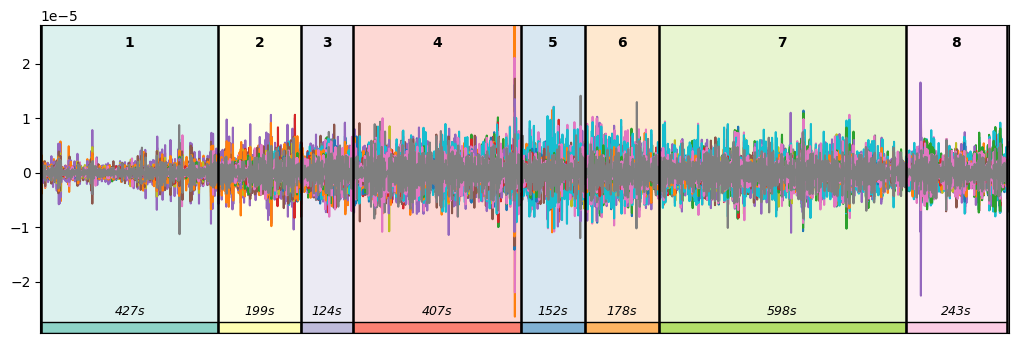

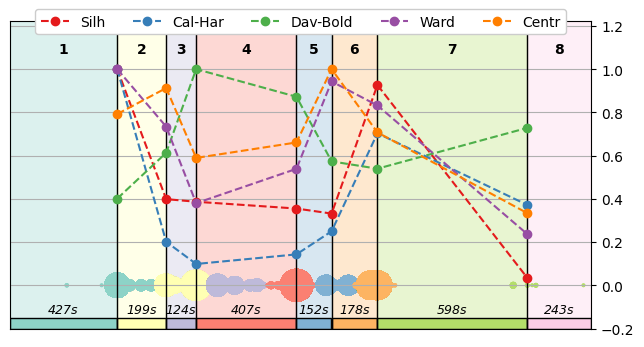

In [17]:
analyze(best_features, 15, "best_topological")

#### Традиционные и топологические вместе + PCA

(2017, 2415)
(2017, 15)
Explained variance 0.44
[0.096, 0.052, 0.04, 0.033, 0.024, 0.023, 0.021, 0.021, 0.02, 0.019, 0.018, 0.018, 0.017, 0.016, 0.016]
Applying to 2017 samples with 15 features each


100%|██████████| 1344/1344 [00:05<00:00, 244.94it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,40,40,20,Mode,40,"[0, 370, 531, 646, 994, 1115, 1275, 1746, 2017]",8,471,115,252.125,...,16.494022,-0.007065,80.949554,3.918795,0.126104,36.170615,3.528825,0.80817,0.659696,0.710919


array([   0,  370,  531,  646,  994, 1115, 1275, 1746, 2017])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(10.5, 434.5)","(436.5, 624.5)","(625.5, 762.5)","(763.5, 1170.5)","(1171.5, 1321.5)","(1323.5, 1502.5)","(1503.5, 2044.5)","(2045.5, 2345.5)"
"Time length, sec",424.0,188.0,137.0,407.0,150.0,179.0,541.0,300.0
Number of epochs,370,161,115,348,121,160,471,271


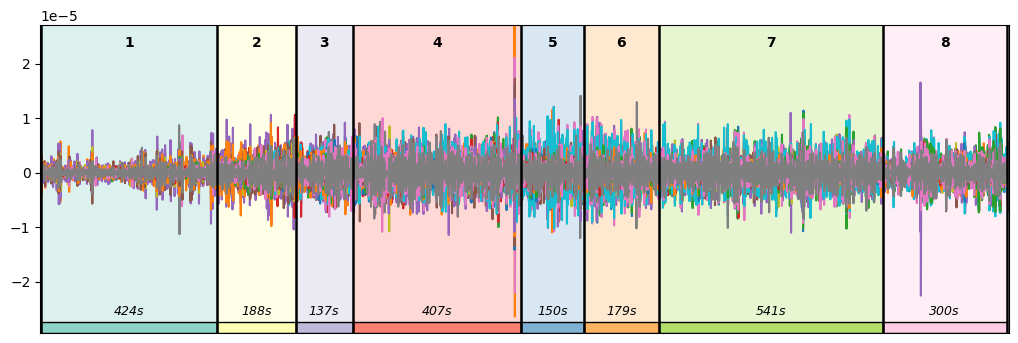

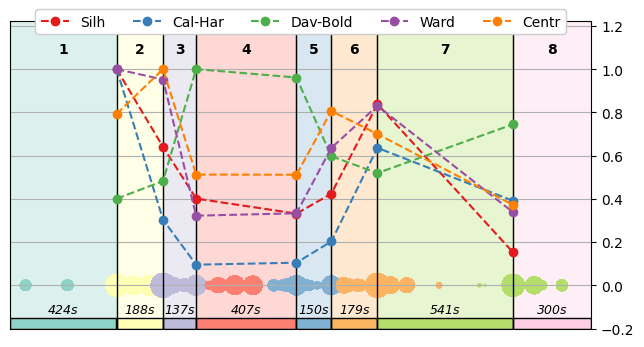

In [18]:
combined_features = pandas.concat([ read_traditional(), best_features ], axis = 1)
analyze(combined_features, 15, "combined")

### Information value

In [19]:
result_edges = numpy.loadtxt(f"{subj}/{exp}/results/best_topological/best_edges.txt").astype(numpy.int32)
print(result_edges)

if os.path.exists(f"{subj}/{exp}/IV/IV.csv"):
    ivs = pandas.read_csv(f"{subj}/{exp}/IV/IV.csv")
else:
    _, labels = SDA.stageprocess.form_stage_bands(result_edges)
    ivs = SDA.analytics.IV.calc_IV_clust(features, labels)

    os.makedirs(f"{subj}/{exp}/IV", exist_ok = True)
    ivs.to_csv(f"{subj}/{exp}/IV/IV.csv", index = False)

ivs["normalized_iv"] = sklearn.preprocessing.MinMaxScaler().fit_transform(ivs[["IV"]])
display(ivs)

[   0  372  542  646  994 1116 1275 1795 2017]


IV: 100%|██████████| 19143/19143 [01:21<00:00, 234.78it/s]


,Feature,IV,IVs,normalized_iv
0,channel-0 betti dim-1 max,0.089330,"[0.1945697834610958, 0.07007211689932236, 0.10...",0.078413
1,channel-0 betti dim-1 mean,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
2,channel-0 betti dim-1 std,0.085795,"[0.08661057918478648, 0.024214131138747996, 0....",0.075309
3,channel-0 betti dim-1 sum,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
4,channel-0 betti dim-1 percentile-25,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
...,...,...,...,...
19138,overall bd2 dim-3 percentile-75,0.935723,"[2.9409523592704634, 0.21168841424686397, 0.53...",0.821360
19139,overall bd2 dim-3 kurtosis,0.062527,"[0.04017676321076237, 0.050860942128424715, 0....",0.054885
19140,overall bd2 dim-3 skew,0.099102,"[0.1662357408690293, 0.1351871429224981, 0.088...",0.086990
19141,overall bd2 dim-3 norm-1,0.128247,"[0.02067839329937159, 0.20877235522570453, 0.0...",0.112573


In [20]:
iv_qsda_scores = scores.join(ivs, lsuffix = "name", rsuffix = "Feature")
iv_qsda_scores = iv_qsda_scores[["name", "unique_values", "score", "normalized_score", "IV", "normalized_iv"]]

iv_qsda_scores["score"] = iv_qsda_scores["score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)
iv_qsda_scores["normalized_score"] = iv_qsda_scores["normalized_score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'score', ascending = False)
iv_qsda_scores["QSDA_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'IV', ascending = False)
iv_qsda_scores["IV_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores["IDX_DIFF"] = iv_qsda_scores["QSDA_IDX"] - iv_qsda_scores["IV_IDX"]

iv_qsda_scores = iv_qsda_scores.sort_index()
display(iv_qsda_scores)

,name,unique_values,score,normalized_score,IV,normalized_iv,QSDA_IDX,IV_IDX,IDX_DIFF
0,channel-0 betti dim-1 max,25,0.000000,0.000000,0.089330,0.078413,19143,6012,13131
1,channel-0 betti dim-1 mean,1,0.000000,0.000000,0.000000,0.000000,18983,16891,2092
2,channel-0 betti dim-1 std,421,0.449305,0.076182,0.085795,0.075309,8419,6200,2219
3,channel-0 betti dim-1 sum,1,0.000000,0.000000,0.000000,0.000000,16024,17711,-1687
4,channel-0 betti dim-1 percentile-25,1,0.000000,0.000000,0.000000,0.000000,16025,17712,-1687
...,...,...,...,...,...,...,...,...,...
19138,overall bd2 dim-3 percentile-75,2013,1.310514,0.222205,0.935723,0.821360,2336,30,2306
19139,overall bd2 dim-3 kurtosis,1963,0.806738,0.136787,0.062527,0.054885,4653,8847,-4194
19140,overall bd2 dim-3 skew,1979,0.252996,0.042897,0.099102,0.086990,11587,5603,5984
19141,overall bd2 dim-3 norm-1,2013,0.264090,0.044778,0.128247,0.112573,11367,4764,6603


<Axes: >

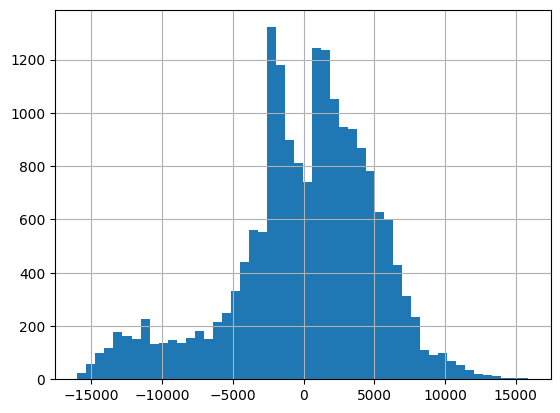

In [21]:
iv_qsda_scores["IDX_DIFF"].hist(bins = 50)

In [22]:
def vec_div(vec):
    mat1 = numpy.repeat(vec.reshape(-1, 1), repeats = len(vec), axis = 1)
    mat2 = numpy.repeat(vec.reshape(1, -1), repeats = len(vec), axis = 0)
    return numpy.sign(mat1 - mat2)

qsda = vec_div(iv_qsda_scores["score"].to_numpy())
iv = vec_div(iv_qsda_scores["IV"].to_numpy())

correct = ((qsda == iv).sum() - iv_qsda_scores.shape[0]) / 2
incorrect = ((qsda != iv).sum() - iv_qsda_scores.shape[0]) / 2

print(correct / 1e6, incorrect / 1e6)

126.914028 56.2940535


In [23]:
def sourceFilter(row):
    if row['Source'].startswith('dissim'):
        return 'dissim'
    return row['Source']

iv_qsda_scores[["Source", "Algorithm", "Dimension", "Stat"]] = iv_qsda_scores['name'].str.split(' ', expand = True)
iv_qsda_scores["Source"] = iv_qsda_scores.apply(sourceFilter, axis = 1)
iv_qsda_scores.to_csv(f"{subj}/{exp}/IV/iv_qsda_scores.csv", index = False)

In [24]:
def SourceRenamer(initial: str) -> str:
    if initial == 'dissim':
        return 'Correlations analysis'
    if initial == 'overall':
        return 'Overall processing'
    ind = initial.find('-') + 1
    comp = int(initial[ind:])
    return f'Comp. {comp} (ch. {epochs.ch_names[comp]})'

def AlgorithmRenamer(row):
    return {
        'amplitude-betti-1':        'Betti amp. with p=1',
        'amplitude-betti-2':        'Betti amp. with p=2',

        'amplitude-bottleneck':     'Bottleneck amp.',
        'amplitude-wasserstein-1':  'Wasserstein amp. with p=1',
        'amplitude-wasserstein-2':  'Wasserstein amp. with p=2',
        
        'amplitude-landscape-1-1':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-1-2':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-2-1':  'Pers. landscape amp. with p=2',
        'amplitude-landscape-2-2':  'Pers. landscape amp. with p=2',
        
        'amplitude-silhouette-1-1': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-1-2': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-2-1': 'Pers. silhouette amp. with p=2',
        'amplitude-silhouette-2-2': 'Pers. silhouette amp. with p=2',

        'bd2':                      'Stat. char. of (b + d) / 2',
        'life':                     'Stat. char. of lifetimes',
        'betti':                    'Stat. char. of Betti curves',
        'landscape':                'Stat. char. of pers. landscape',
        'silhouette-1':             'Stat. char. of lvl 1 pers. silh.',
        'silhouette-2':             'Stat. char. of lvl 2 pers. silh.',
        
        'entropy':                  'Persistence entropy',
        'numberofpoints':           'Number of points',
    }[row]

def DimensionRenamer(row):
    return {
        'all':        'All',
        'dim-1':      'Dimension 1',
        'dim-2':      'Dimension 2',
        'dim-3':      'Dimension 3',
        'dim-4':      'Dimension 4',
        'dim-5':      'Dimension 5',
        'norm-1':     'Amplitude norm with p=1',
        'norm-2':     'Amplitude norm with p=2',
    }[row]

def StatRenamer(row):
    return {
        'kurtosis':      'Kurtosis',
        'skew':          'Skew',
        'max':           'Maximum',
        'mean':          'Mean',
        'median':        'Median',
        'norm-1':        'Norm with p=1',
        'norm-2':        'Norm with p=2',
        'percentile-25': 'Percentile - 25',
        'percentile-75': 'Percentile - 75',
        'std':           'Standard deviation',
        'sum':           'Sum',
    }[row]

def make_stats(data: pandas.DataFrame, group_by: str, sort_by: str):
    stats = data.groupby(by = group_by).mean(numeric_only = True)
    stats = stats.sort_values(by = sort_by).reset_index()
    stats.to_csv(f"{subj}/{exp}/IV/stats_{group_by}_{sort_by}.csv", index = False)
    return stats

def draw(
    data: pandas.DataFrame,
    group_by: str,
    sort_by: str,
    ax,
    renamer: typing.Callable[[str], str],
    title: str
):
    stats = make_stats(data, group_by, sort_by)
    stats[group_by] = stats[group_by].apply(renamer)
    stats.plot.barh(x = group_by, y = sort_by, ax = ax, xlim = (2 * stats[sort_by].min() / 3, None))

    ax.set_title(title)
    ax.get_legend().remove()
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

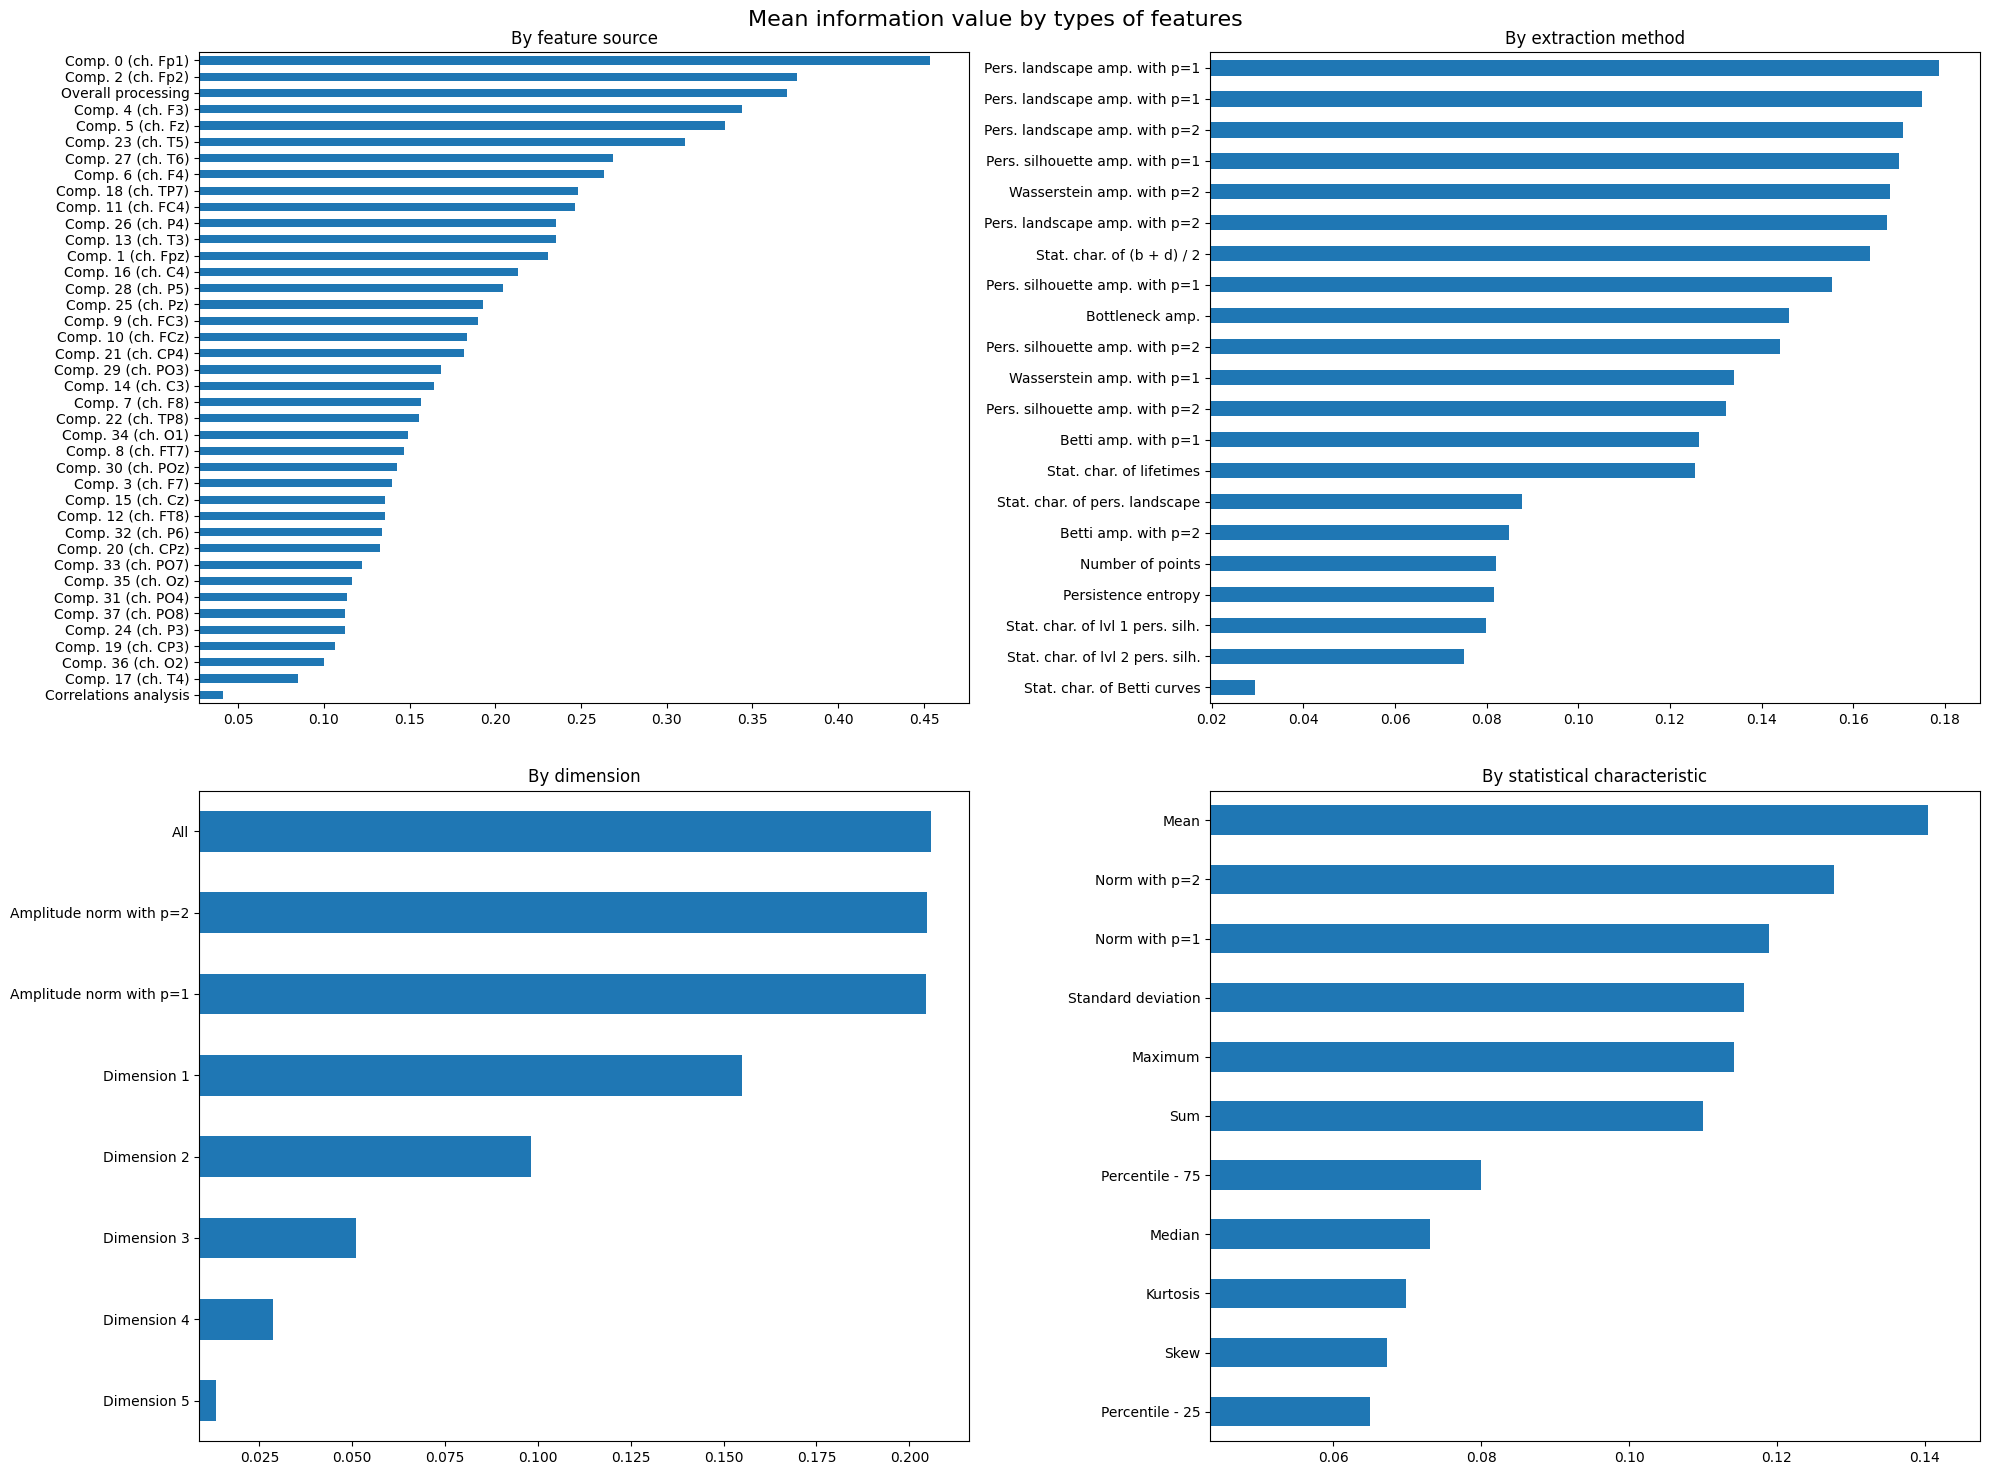

In [25]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean information value by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'IV', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'IV', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'IV', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'IV', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.png")

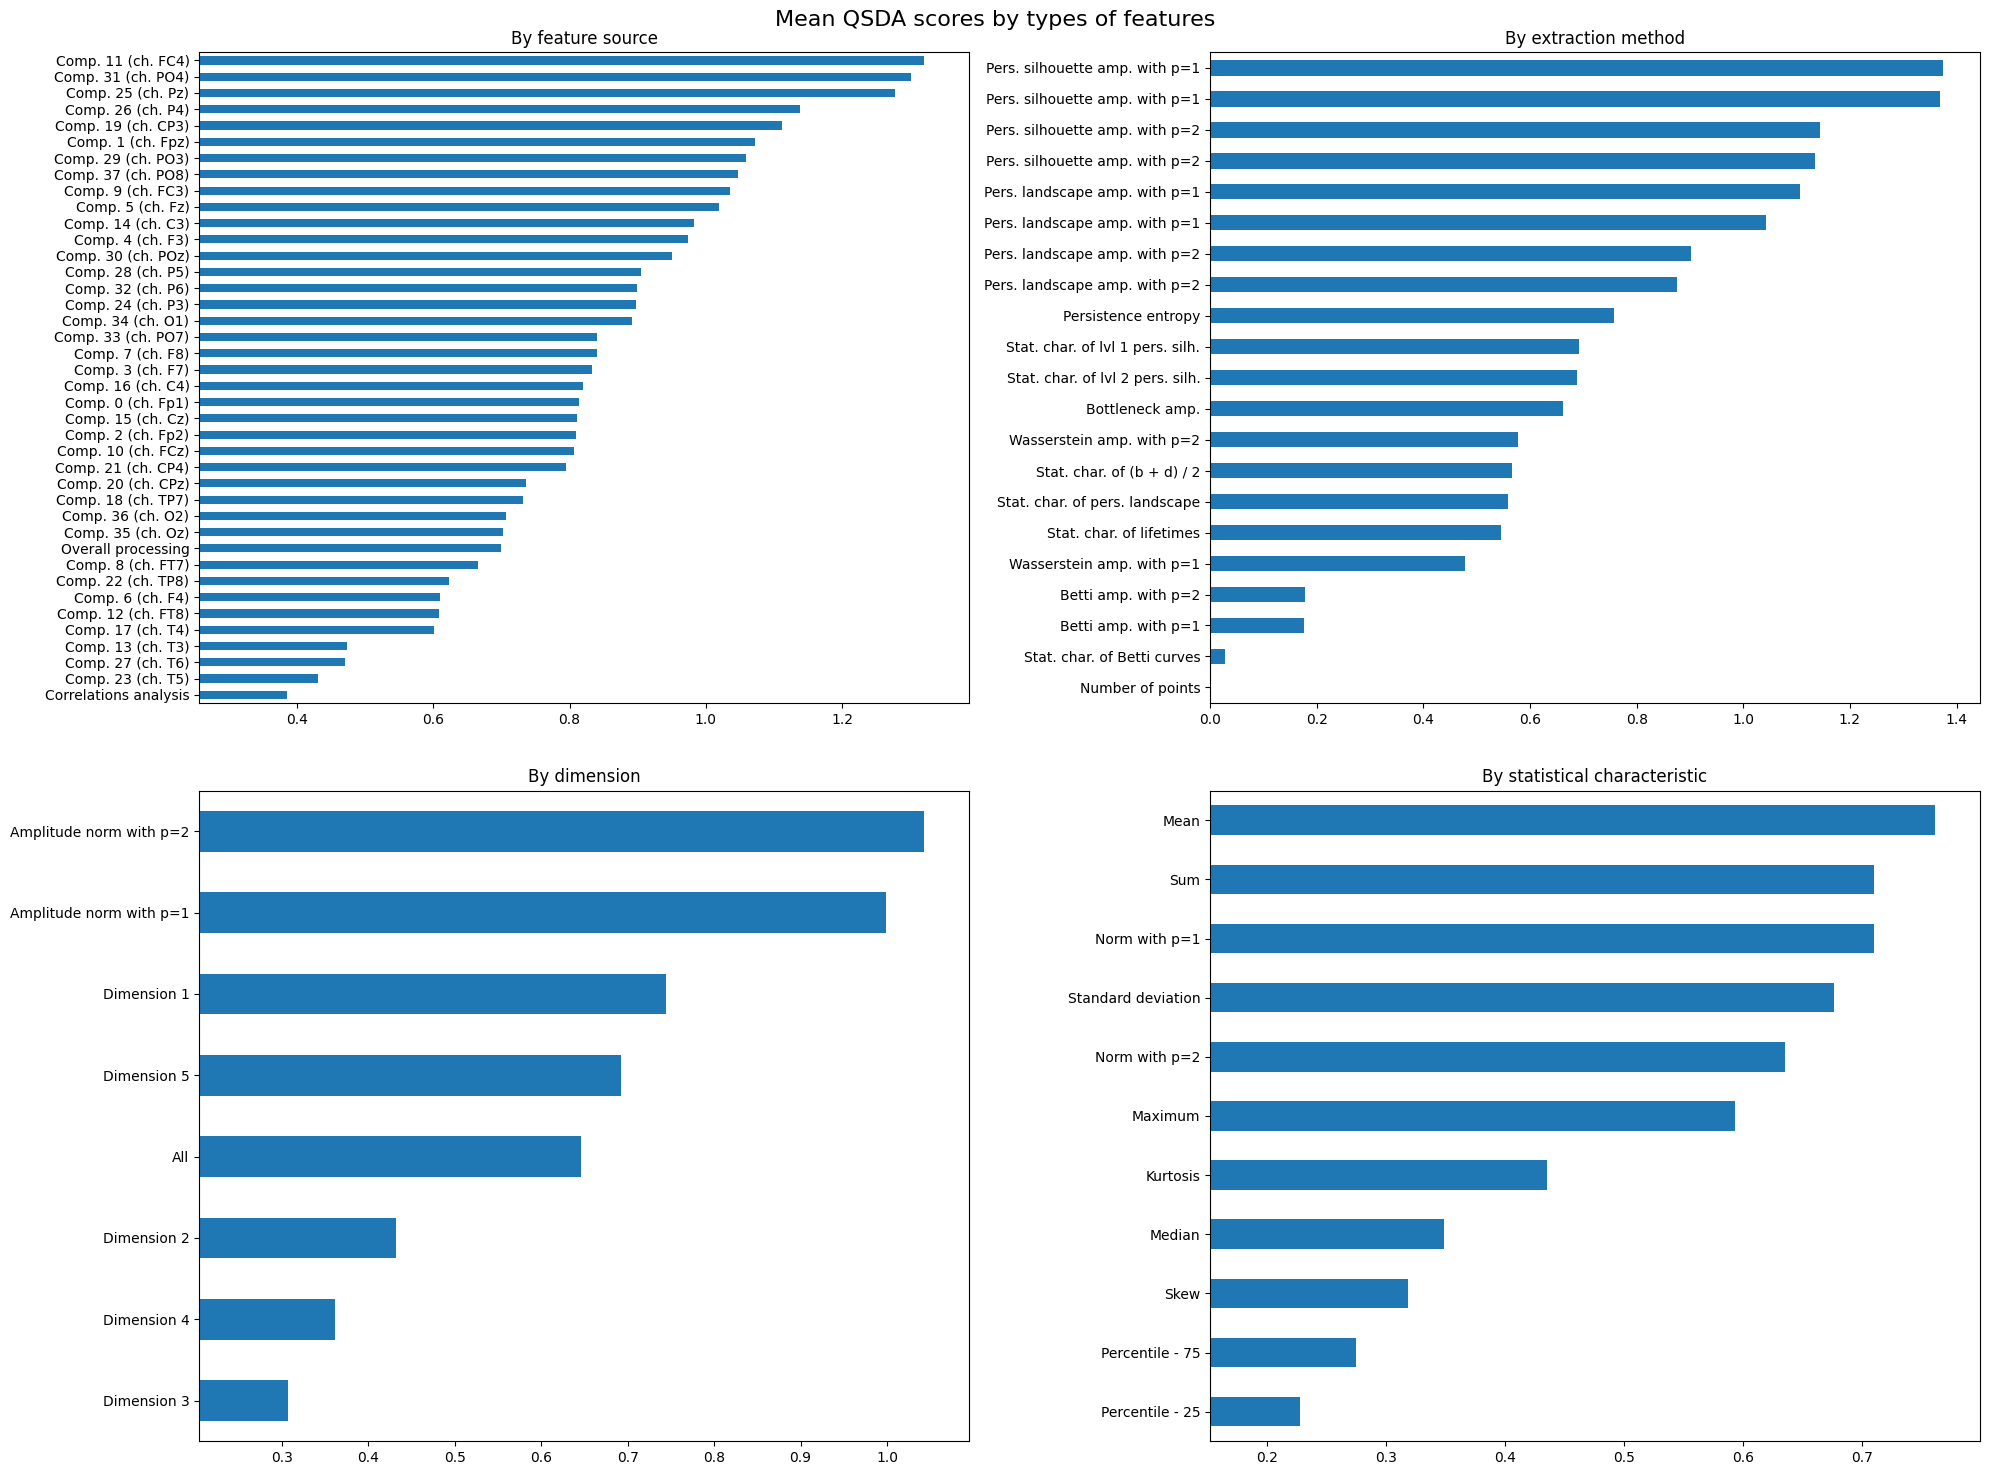

In [26]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean QSDA scores by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'score', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'score', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'score', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'score', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.png")

In [28]:
def draw_sources_heatmap(data: pandas.DataFrame, sort_by: str):
    svg = open("report/regions/regions.svg", "r").read()
    svg = svg[svg.find('>') + 1:svg.rfind('<') - 1]
    defs = ""

    stats = make_stats(data, "Source", sort_by)[["Source", sort_by]]
    stats = stats[stats.apply(lambda row: row['Source'].startswith('channel-'), axis = 1)]

    min, max = stats[sort_by].min(), stats[sort_by].max()
    colors = [[ 1, 0.25, 0 ], [ 1, 0.66, 0 ], [ 1, 0.75, 0 ], [ 0.66, 0.8, 0 ], [ 0.25, 1, 0 ]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('rg', colors, N = int((max - min) * 1000))

    for _, row in stats.iterrows():
        score = int((row[sort_by] - min) * 1000)
        color = matplotlib.colors.rgb2hex(cmap(score))

        id = int(row['Source'][row['Source'].find('-') + 1:])
        id_index = svg.index(f'id="{id}"')
        path_start = svg.rfind("<", 0, id_index)
        path_end = svg.find(">", id_index)

        path = svg[path_start:path_end+1]
        m_idx = path.find("M")
        x = float(path[m_idx + 1:m_idx + 7])
        y = float(path[m_idx + 8:m_idx + 15])

        defs += f"""
            <radialGradient id="gradient{id}">
                <stop offset="0%" stop-color="{color}" stop-opacity="0.66"></stop>
                <stop offset="100%" stop-color="{color}" stop-opacity="0"></stop>
            </radialGradient>
        """
        part = f"""
            <circle cx="{x}" cy="{y - 2}" r="50" fill="url(#gradient{id})"></circle>
            {path.replace(f'id="{id}"', f'fill="{color}" stroke="{color}"')}
        """

        svg = svg[:path_start] + part + svg[path_end+1:]

    svg = f"""
        <svg viewBox="0 0 530 528" fill="none" xmlns="http://www.w3.org/2000/svg">
            <defs> {defs} </defs> {svg}
        </svg>
    """

    file = f"{subj}/{exp}/IV/{sort_by}_regions.svg"
    open(file, "w").write(svg)
    return IPython.display.SVG(file)

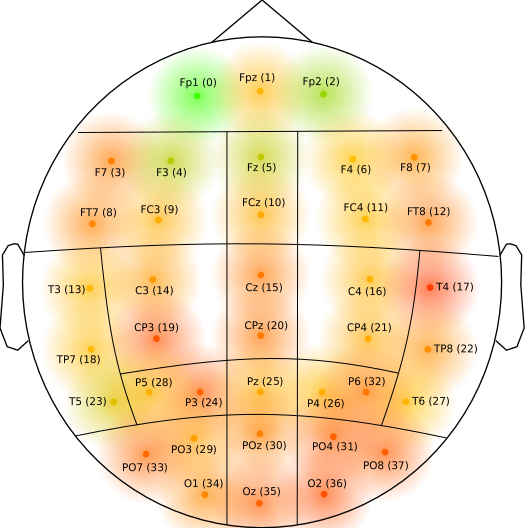

In [29]:
draw_sources_heatmap(iv_qsda_scores, "IV")

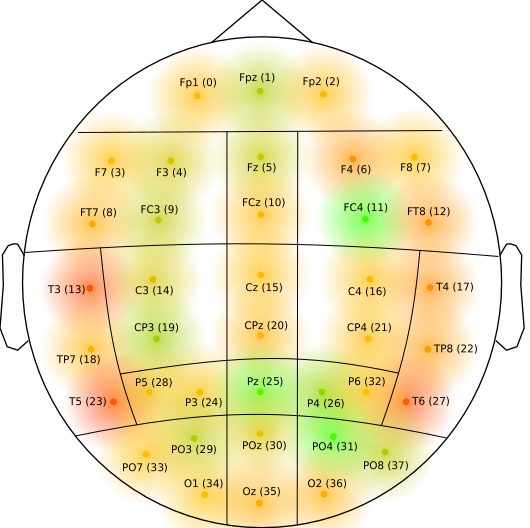

In [30]:
draw_sources_heatmap(iv_qsda_scores, "score")